In [77]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.sparse.linalg import spsolve

In [78]:
# Numerical parameters
nr = 200 # number of grid points
relaxation_parameter=.01 # used in nonlinear loop.
maxiter=300

# Define physical constants and parameters
# Physical constants
seconds_in_year = 3.1558e7
R=8.314e-3     # in kJ/mol/K
# Boundary conditions and internal heating
H=0 # internal heating rate.
Tb=270
Ts=100
Ro = 2.52e5             # outer radius of ice shell (m)
Ri = 2.52e5-12e3         # inner radius of ice shell (m)
Rc = 1.60e5             # core radius (m)
# Elastic and Viscous properties
E = 5e9        # shear modulus of ice (Pa)
nu = 0.3      # Poisson ratio of ice (-)
beta_w = 4e-10 # Compressibility of water (1/Pa)
alpha_l = 1e-4 # coefficient of linear thermal expansion ( alpha_v/3 ) (1/K)
rho_i=900      # density of ice (kg/m^3)
rho_w=1000     # density of water (kg/m^3)
Q=40           # activation energy, kJ/mol, Nimmo 2004 (kJ/mol)
mub=1e15       # basal viscosity (Pa-s)
mu = lambda T: mub * math.exp(Q * (Tb-T) / R / Tb / T) # function to evaluate viscosity in Pa-s given T
g = 0.113      # used to plot a failure curve
tau = 3e6 # tensile strength, Pa
# Thermal properties
Cp = 2100 #heat capacity of ice J/kg/K
Lf = 334*1000 # latent heat of fusion (J/kg)
kappa = 1e-6# m/s/s
k=kappa*rho_i*Cp

In [79]:
# calculate maxwell time at 100, 270
print('Maxwell time at surface, base', mu(100)/E, mu(Tb)/E)
print('Thermal diffusion timescale', (4e4)**2/kappa)

Maxwell time at surface, base 2.8634918187625016e+18 200000.0
Thermal diffusion timescale 1600000000000000.0


In [80]:
# set end time and grid resolution
t_end = 0.5e6*seconds_in_year;

dtmax = 1e3*seconds_in_year;
dtmin = seconds_in_year;

plot_interval = t_end;
save_interval = 1e5*seconds_in_year;
save_depths = np.array([0, 1, 2, 3, 5]) * 1000;
nsave = math.ceil(t_end/save_interval) + 1; nsave_depths = len(save_depths);
sigma_t_store = np.zeros((nsave_depths,nsave))


In [81]:
# set up the grid
grid_r = np.linspace(Ri,Ro,nr)

In [82]:
# initialize solution vectors (IC)
sigma_r_last = np.zeros(nr) # initial stresses
sigma_t_last = np.zeros(nr) # initial stresses
T_last = np.linspace(Tb,Ts,nr).T
er_last = np.zeros(nr) # strains
et_last = np.zeros(nr)
ur_last = np.zeros(nr)      # displacement
z_last = 0 # total amount of thickening
figPex_last = 0 #initial overpressure

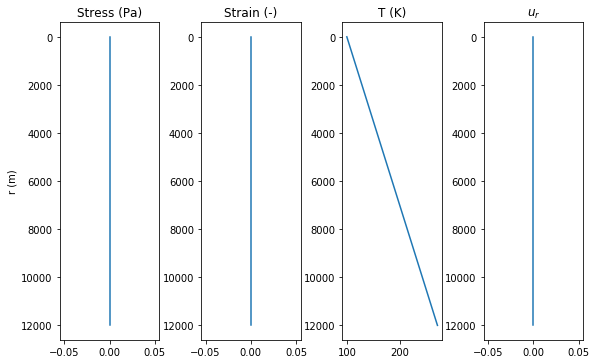

In [83]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(8,5))
fig.tight_layout()

# Set up plot
plot_times = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]) * 1e6 * seconds_in_year
iplot = 2

ax1.plot(sigma_r_last, Ro-grid_r)
ax1.set_title('Stress (Pa)')
ax1.set_ylabel('r (m)')
ax1.invert_yaxis()

# subplot(1,4,2) # e_r and e_t
ax2.plot(sigma_r_last, Ro-grid_r)
ax2.set_title('Strain (-)')
ax2.invert_yaxis()

# subplot(1,4,3) # temperature
ax3.plot(T_last,Ro-grid_r)
ax3.set_title('T (K)')
ax3.invert_yaxis()

# subplot(1,4,4) # radial displacement (u)
ax4.plot(ur_last,Ro-grid_r)
ax4.set_title(r'$u_r$')
ax4.invert_yaxis()


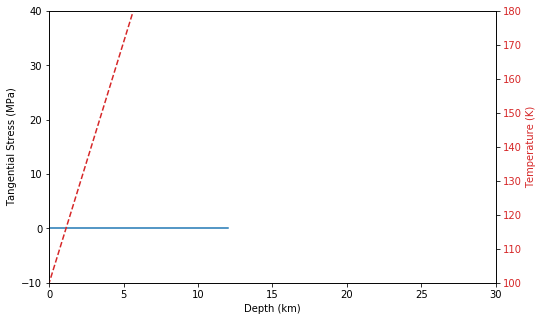

In [84]:
# fig1a.h = figure() # Nimmo's Figure 1a
fig, ax = plt.subplots(1, 1, figsize=(8,5))

# [ax,h1,h2]=plotyy((Ro-grid_r)/1e3,sigma_t_last/1e6,(Ro-grid_r)/1e3,T_last)
ax.set_xlabel('Depth (km)')
ax.set_ylabel('Tangential Stress (MPa)')
ax.plot((Ro-grid_r)/1e3, sigma_t_last/1e6)
ax.set_xlim(0, 30)
ax.set_ylim(-10, 40)

color = 'tab:red'
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)', color=color)
ax2.set_ylim(100, 180)
ax2.plot((Ro-grid_r)/1e3, T_last, color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# fig1a.ax = ax
# h2.Color = h1.Color
# h2.LineStyle = '--'
# hold(ax(1)) hold(ax(2))
# set(ax,'Xlim',[0 30])
# set(ax(1),'YLim',[-10 40])
# set(ax(1),'YTick',[-10:5:40])
# set(ax(2),'YTick',[100:20:180])
# set(ax(1),'YTickLabelMode','auto')
# ylabel(ax(1),'Tangential Stress (MPa)')
# xlabel(ax(1),'Depth (km)')
# ylabel(ax(2),'Temperature (K)')
# set(ax(2),'YLim',[100 180])

In [85]:
time=0 
itime=1
time_store = []
Pex_last = 0
# save initial state

isave = 0
sigma_t_store[:,isave] = np.interp(save_depths, Ro-grid_r, sigma_t_last)
time_store.append(time)
last_store = time 
isave += 1

In [86]:
def interpolate_solution(new_grid_r, grid_r, T_last, sigma_r_last, sigma_t_last, er_last, et_last, Tb):
    interp_r = np.copy(grid_r)
    interp_r[0] = new_grid_r[0]
    
    tmp = T_last
    tmp[0] = Tb
    
    tlast = np.interp(new_grid_r, interp_r, tmp)
    sigmarlast = np.interp(new_grid_r, interp_r, sigma_r_last)
    sigmatlast = np.interp(new_grid_r, interp_r, sigma_t_last)
    erlast = np.interp(new_grid_r, interp_r, er_last)
    etlast = np.interp(new_grid_r, interp_r, et_last)
    
    return tlast, sigmarlast, sigmatlast, erlast, etlast

In [87]:
def solve_temperature_shell(grid_r,T_last,Tb,Ts,k,rho_i,Cp,H,dt):
    # Solve the energy equation in spherical coordinates
    # VECTOR inputs
    # grid_r - node locations
    # T_last - last timestep solution
    #
    # SCALAR inputs
    # Tb - basal temperature
    # Ts - surface temperature
    # k - thermal conductivity
    # rho - density
    # Cp - heat capacity
    # H - (constant) internal heating
    # dt - timestep

    nr = len(grid_r)

    L = np.zeros((nr,nr))
    R = np.zeros(nr)
                 
    for i in range(nr):
        r = grid_r[i]
                 
        if i==0:
            drm = grid_r[i+1]-grid_r[i]
        else:
            drm = grid_r[i]-grid_r[i-1]

        if i == nr - 1:
            drp = drm
        else:
            drp = grid_r[i+1]-grid_r[i]
        
        rA = r + drp/2
        rB = r - drm/2
        kA = k # thermal conductivities
        kB = k
        dr = rA-rB
        coef_plus   = -kA*rA**2/r**2/drp/dr
        coef_center =  rho_i*Cp/dt + kA*rA**2/r**2/drp/dr + kB*rB**2/r**2/drm/dr
        coef_minus  = -kB*rB**2/r**2/drm/dr

        if i==0:
            L[i,i] =  coef_center
            #             L(i,i+1) = coef_plus-coef_minus
            #             R(i) = R(i) - 2*Tb*coef_minus
            R[i] = coef_center*Tb
        elif i==nr-1:
            L[i,i] =  coef_center
            #             L(i,i-1) = coef_minus-coef_plus
            #             R(i) = R(i) - 2*Ts*coef_plus
            R[i] = coef_center*Ts
        else:
            L[i,i] =  coef_center
            L[i,i-1] = coef_minus
            L[i,i+1] = coef_plus
            R[i] = rho_i*Cp/dt*T_last[i] + H

    T = np.linalg.solve(L, R)
    
    return T


In [88]:
def solve_stress_viscoelastic_shell(grid_r,mu,sigma_r_last,alpha_dTdotdr,Pex,E,nu,dt):
    # Solver for viscoelastic stresses
    # Subject to basal pressure boundary condition given by Pex
    # surface boundary condition is sigma_r = 0 (free surface)
    #
    # VECTOR inputs
    # grid_r contains nodal coordinates
    # mu contains viscosities at each node
    # sigma_r_last contains previous stress (sigma_r) values
    # alpha_dTdotdr is the alpha_l * d/dt(dT/dr)
    #
    # SCALAR inputs
    # Pex excess pressure
    # E shear modulus
    # nu poisson ratio
    # dt timestep
    #
    #

    nr = len(grid_r)

    M1 = np.zeros((nr,nr)) # coefficients on (dsigma/dt)
    M2 = np.zeros((nr,nr)) # coefficients on (sigma_r)
    R = np.zeros(nr)

    for i in range(nr):
        if i == 0:
            drm = grid_r[i+1]-grid_r[i]
        else:
            drm = grid_r[i] - grid_r[i-1]
        
        if i == nr-1:
            drp = grid_r[i] - grid_r[i-1]
        else:
            drp = grid_r[i+1] - grid_r[i]
        
        rA = grid_r[i]+drp/2 # half a cell +
        rB = grid_r[i]-drm/2   # half a cell -
        drc = rA-rB
        this_mu = mu[i] # viscosity
        
        # M1 - coefficients of dsigma_r/dt
        const1 = (3-3*nu)/(2*E)
        const2 = (1-nu)/E # coefficient on d(r/2 d/dr)/dr term
        coef_a = rA/2/drp/drc
        coef_b = rB/2/drm/drc
        coef_plus   =1/dt*(  const1/(drp+drm)    + const2*coef_a)
        coef_center =1/dt*(                       -const2*coef_a - const2*coef_b)
        coef_minus  =1/dt*( -const1/(drp+drm)    + const2*coef_b)
        if i==0:
            pass
            #                 M1(i,i)   = coef_center
            #                 M1(i,i+1) = coef_plus-coef_minus
            #                 R(i) = R(i) - 2*coef_minus*P
        elif i==nr-1:
            M1[i,i-1] = coef_minus-coef_plus
            M1[i,i]   = coef_center
            R[i] = R[i] - 2*coef_plus*0
        else:
            M1[i,i-1] = coef_minus
            M1[i,i]   = coef_center
            M1[i,i+1] = coef_plus
        
        # M2 - coefficients of sigma_r
        if i == 0:
            mu_B = mu[i]
        else:
            mu_B = np.exp(np.mean(np.log([mu[i-1], mu[i]]))) # viscosity halfway between nodes i,i+1
        
        if i == nr-1:
            mu_A = mu[i]
        else:
            mu_A = np.exp(np.mean(np.log([mu[i], mu[i+1]]))) # viscosity halfway between nodes i,i+1
        
        coef_plus   = 1/(4*this_mu)/(drp+drm) + rA/12/mu_A/drp/drc
        coef_center =                          -rA/12/mu_A/drp/drc - rB/12/mu_B/drm/drc
        coef_minus  =-1/(4*this_mu)/(drp+drm) + rB/12/mu_B/drm/drc
        if i==0:
            M2[i,i]   = coef_center
            M2[i,i+1] = coef_plus-coef_minus
            R[i] = R[i] - 2*coef_minus*Pex
        elif i==nr-1:
            M2[i,i-1] = coef_minus-coef_plus
            M2[i,i]   = coef_center
            R[i] = R[i] - 2*coef_plus*0 # surface sigma_r = 0
        else:
            M2[i,i-1] = coef_minus
            M2[i,i]   = coef_center
            M2[i,i+1] = coef_plus
        
        if i==0:
            R[i] = R[i] - coef_minus*2*Pex
            M2[i,i+1] = M2[i,i+1] - coef_minus
        elif i==nr-1:
            M2[i,i-1] = M2[i,i-1] - coef_plus
            R[i] = R[i] - coef_plus*0 # no change because sigma_r = 0 at surface
        
        R[i] = R[i] - alpha_dTdotdr[i]
        #         R(i) = R(i)+alpha_l*(Tdot(i+1)-Tdot(i))/2/drc # this term
        #         includes the coupling to the energy equation - Tdot needs
        #         to be updated
    
    LHS = (M1+M2)
    R1term = M1 @ sigma_r_last # this represents terms involving dsigma/dr at previous timestep
    RHS = (R+R1term)

    LHS[0,:] = 0
    LHS[0,0] = abs(LHS[1,1])
    RHS[0]   = Pex*LHS[0,0]
    LHS[-1,:] = 0
    LHS[-1, -1] = abs(LHS[-2,-2])
    RHS[-1] = LHS[-1, -1]*0
    
    LHS = sps.csr_matrix(LHS)
    sigma_r = spsolve(LHS, RHS)

    # 4. calculate the tangential stress sigma_t
    # first, calculate dsr/dr
    dsrdr = np.zeros(sigma_r.shape)
    for i in range(1, nr-1):
        dr = grid_r[i+1]-grid_r[i-1]
        dsrdr[i] = (sigma_r[i+1]-sigma_r[i-1])/dr
    
    sigma_g = Pex - (sigma_r[1] - Pex)
    dsrdr[0] =  (sigma_r[1]-sigma_g)/2/(grid_r[1]-grid_r[0]) # special formula using ghost value
    sigma_g = 0 - (sigma_r[nr-2] - 0)
    dsrdr[-1] = (sigma_g-sigma_r[-2])/2/(grid_r[-1]-grid_r[-2])

    sigma_t = sigma_r+(grid_r.T/2) * dsrdr

    #deviatoric stresses, from Hillier and Squyres (1991) equations A8-9
    sigma_tD =  (grid_r / 6) * dsrdr
    sigma_rD = (-grid_r / 3) * dsrdr
    
    return sigma_r, sigma_t, sigma_rD, sigma_tD

In [89]:
while time < t_end:
    # In each timestep, we do the following
    # 1. Calculate the amount of basal freeze-on and advance the mesh
    # 2. Solve the heat equation using an implicit method
    # 3. Solve for sigma_r
    # 4. Calculate sigma_t
    # 5. Calculate the radial displacements u(r)
    
    # 1. Calculate basal freeze-on and interpolate old solution onto new mesh
    # calculate heat flux
    Tg = Tb-(T_last[1]-Tb)
    dTdr_b_last = (T_last[1]-Tg)/2/(grid_r[1]-grid_r[0])
    qb = -k*dTdr_b_last
    
    # determine the timestep
    dt = dtmax
    if np.abs(qb/Lf/rho_i*dt) > (grid_r[1]-grid_r[0])/2:
       dt =  (grid_r[1]-grid_r[0])/2/(qb/Lf/rho_i)
    
    if dt < dtmin:
        dt = dtmin
    
    # thickening would be dx/dt = qb/(L*rho_i)    
    delta_rb = dt*qb/Lf/rho_i
    z = z_last + delta_rb
    
    # calculate new ocean pressure (Manga and Wang 2007, equation 5)
    Pex_pred = Pex_last + 3*Ri**2/beta_w/(Ri**3-Rc**3)*(delta_rb*(rho_w-rho_i)/rho_w-ur_last[0]) # ur_last because we don't yet know the uplift
    
    # re-mesh onto new grid
    new_grid_r = np.linspace(Ri-z,Ro,nr)
    T_last,sigma_r_last,sigma_t_last,er_last,et_last = interpolate_solution(new_grid_r,grid_r,T_last,sigma_r_last,sigma_t_last,er_last,et_last,Tb)

    grid_r = new_grid_r # end interpolation step
    
    # 2. form discrete operators and solve the heat equation
    T = solve_temperature_shell(grid_r,T_last,Tb,Ts,k,rho_i,Cp,H,dt)
    
    #Compute d(Tdot)/dr
    Tdot = (T-T_last)/dt
    dTdr_b = (T[1]-T[0])/(grid_r[1]-grid_r[0])
    Tdot[0] = delta_rb*dTdr_b/dt # this is an approximation to the Eulerian cooling rate at the ocean-ice interface
    
    dTdotdr = np.zeros(nr)
    for i in range(1, nr-2):
        dTdotdr[i] = (Tdot[i+1]-Tdot[i-1])/(grid_r[i+1]-grid_r[i-1])

    dTdotdr[0] = (Tdot[1]-Tdot[0])/(grid_r[1]-grid_r[0])
    dTdotdr[nr-1] = (Tdot[nr-1]-Tdot[nr-2])/(grid_r[nr-1]-grid_r[nr-2])
    
    # 3. Nonlinear loop over pressure.
    # because the ocean pressure depends on the uplift, we make a guess
    # (above). Using this guess, we calculate stresses, strains, and
    # displacements. Then we re-calculate the pressure using the new value
    # of radial displacement. We continue until the pressure used in the
    # calculations has converged to the pressure consistent with the
    # calculated displacement
    for iterator in range(maxiter):
        if iterator > 0:
            Pex = Pex + relaxation_parameter*(Pex_post-Pex)
        else:
            Pex = Pex_pred
        
        # calculate viscosity at each node
        mu_node = np.zeros(nr)
        for i in range(nr):
            mu_node[i] = mu(T[i])
        
        sigma_r,sigma_t,sigma_rD,sigma_tD = solve_stress_viscoelastic_shell(grid_r,mu_node,sigma_r_last,alpha_l*dTdotdr,-Pex,E,nu,dt)
               
        # 5. Calculate the strains        
        dT = T-T_last
        dT[0] = delta_rb*dTdr_b
        
        dsigma_t = sigma_t - sigma_t_last
        dsigma_r = sigma_r - sigma_r_last
        
        de_t = 1/E*(dsigma_t-nu*(dsigma_t+dsigma_r)) + alpha_l * dT + dt/2 * (sigma_tD / mu_node) # change in tangential strain
        de_r = 1/E*(dsigma_r-2*nu*dsigma_t)          + alpha_l * dT + dt/2 * (sigma_rD / mu_node) # HS91 equations A5-6
        er = er_last + de_r
        et = et_last + de_t
        ur = grid_r*et #radial displacement
        
        # re-calculate excess pressure using new uplift
        Pex_post = 3*Ri**2/beta_w/(Ri**3-Rc**3)*(z*(rho_w-rho_i)/rho_w-ur[0]) # ur_last because we don't yet know the uplift
        
        # check for convergence
        if abs( Pex_post-Pex )/abs(Pex) < 1e-2:
            print(f'dt={dt/seconds_in_year} yr, time={(time+dt)/seconds_in_year/1e6} Myr, Pex_post {Pex_post} Pex {Pex}, converged in {iterator} iterations')
            break
        elif iterator == maxiter - 1:
            raise Error('Nonlinear loop failed to converge')

    
    # 6. advance to next time step and plot (if needed)
    sigma_r_last = sigma_r
    sigma_t_last = sigma_t
    T_last = T
    er_last = er
    et_last = et
    z_last = z
    ur_last = ur
    Pex_last = Pex
    
    time = time + dt
    
    if time >= plot_times[iplot-1] or time >= t_end:
        iplot += 1
        print('Adding to plot')
        
#         figure(hf)
#         subplot(1,4,1)
#         h=plot(sigma_r,Ro-grid_r)
#         plot(sigma_t,Ro-grid_r,'--','Color',h.Color)
#         subplot(1,4,2)
#         h=plot(er,Ro-grid_r)
#         plot(et,Ro-grid_r,'--','Color',h.Color)
#         subplot(1,4,3)
#         plot(T,Ro-grid_r)
#         subplot(1,4,4)
#         plot(ur,Ro-grid_r)
        
        
#         figure(hf2)
#         plot(ur(end),sigma_t(end),'.') hold on
        
#         figure(fig1a.h) # Nimmo's Figure 1a
#         h=plot(fig1a.ax(1),(Ro-grid_r)/1e3,sigma_t_last/1e6)
#         plot(fig1a.ax(2),(Ro-grid_r)/1e3,T_last,'--','Color',h.Color)
        
        
#         last_plot_time = time
#         drawnow()
    
    if time-last_store >= save_interval or time >= t_end:
        sigma_t_store[:,isave] = np.interp(save_depths, Ro-grid_r, sigma_t_last)
        time_store.append(time)
        last_store = time 
        isave += 1       


dt=1000.0 yr, time=0.001 Myr, Pex_post 487.98108726575293 Pex 491.3836660986288, converged in 21 iterations
dt=1000.0 yr, time=0.002 Myr, Pex_post 886.1930470460252 Pex 878.9666269330864, converged in 10 iterations
dt=1000.0 yr, time=0.003 Myr, Pex_post 1240.373634277455 Pex 1229.6764424630046, converged in 19 iterations
dt=1000.0 yr, time=0.004 Myr, Pex_post 1571.3975531940637 Pex 1559.2994159628433, converged in 20 iterations
dt=1000.0 yr, time=0.005 Myr, Pex_post 1892.3652892006066 Pex 1874.2320296259716, converged in 20 iterations
dt=1000.0 yr, time=0.006 Myr, Pex_post 2192.028215544212 Pex 2178.3335753717706, converged in 21 iterations
dt=1000.0 yr, time=0.007 Myr, Pex_post 2490.4284013491088 Pex 2473.3131287710885, converged in 21 iterations
dt=1000.0 yr, time=0.008 Myr, Pex_post 2781.3696131919482 Pex 2760.8365665884403, converged in 21 iterations
dt=1000.0 yr, time=0.009 Myr, Pex_post 3065.896483076159 Pex 3041.94604053991, converged in 21 iterations
dt=1000.0 yr, time=0.01 Myr

dt=1000.0 yr, time=0.077 Myr, Pex_post 17336.396098047615 Pex 17189.480803936534, converged in 22 iterations
dt=1000.0 yr, time=0.078 Myr, Pex_post 17511.36902616024 Pex 17362.46001435449, converged in 22 iterations
dt=1000.0 yr, time=0.079 Myr, Pex_post 17685.738513811477 Pex 17534.834272305343, converged in 22 iterations
dt=1000.0 yr, time=0.08 Myr, Pex_post 17859.512439616137 Pex 17706.612328484036, converged in 22 iterations
dt=1000.0 yr, time=0.081 Myr, Pex_post 18032.70015715587 Pex 17877.802715243764, converged in 22 iterations
dt=1000.0 yr, time=0.082 Myr, Pex_post 18205.31007618367 Pex 18048.41381020784, converged in 22 iterations
dt=1000.0 yr, time=0.083 Myr, Pex_post 18377.349930166038 Pex 18218.45379550221, converged in 22 iterations
dt=1000.0 yr, time=0.084 Myr, Pex_post 18548.8275341459 Pex 18387.930740976786, converged in 22 iterations
dt=1000.0 yr, time=0.085 Myr, Pex_post 18719.751728725092 Pex 18556.852454230353, converged in 22 iterations
dt=1000.0 yr, time=0.086 Myr

dt=1000.0 yr, time=0.153 Myr, Pex_post 29230.79124404309 Pex 29058.128766945152, converged in 23 iterations
dt=1000.0 yr, time=0.154 Myr, Pex_post 29375.377073558553 Pex 29201.495380469998, converged in 23 iterations
dt=1000.0 yr, time=0.155 Myr, Pex_post 29519.7232768501 Pex 29344.620205674106, converged in 23 iterations
dt=1000.0 yr, time=0.156 Myr, Pex_post 29663.830804477573 Pex 29487.50581597636, converged in 23 iterations
dt=1000.0 yr, time=0.157 Myr, Pex_post 29807.70433665119 Pex 29630.154712909694, converged in 23 iterations
dt=1000.0 yr, time=0.158 Myr, Pex_post 29951.345716499338 Pex 29772.569403941125, converged in 23 iterations
dt=1000.0 yr, time=0.159 Myr, Pex_post 30094.756041891917 Pex 29914.75252455137, converged in 23 iterations
dt=1000.0 yr, time=0.16 Myr, Pex_post 30237.93850239975 Pex 30056.70645959295, converged in 23 iterations
dt=1000.0 yr, time=0.161 Myr, Pex_post 30380.896568349064 Pex 30198.43348627724, converged in 23 iterations
dt=1000.0 yr, time=0.162 Myr,

dt=1000.0 yr, time=0.23 Myr, Pex_post 39818.2636571297 Pex 39546.281964059825, converged in 23 iterations
dt=1000.0 yr, time=0.231 Myr, Pex_post 39950.25979287946 Pex 39676.90311285073, converged in 23 iterations
dt=1000.0 yr, time=0.232 Myr, Pex_post 40082.15290207645 Pex 39807.41841849803, converged in 23 iterations
dt=1000.0 yr, time=0.233 Myr, Pex_post 40213.94343093648 Pex 39937.82894260072, converged in 23 iterations
dt=1000.0 yr, time=0.234 Myr, Pex_post 40345.63292291702 Pex 40068.13590323451, converged in 23 iterations
dt=1000.0 yr, time=0.235 Myr, Pex_post 40477.222255587556 Pex 40198.34040827518, converged in 23 iterations
dt=1000.0 yr, time=0.236 Myr, Pex_post 40608.713220878686 Pex 40328.44349255152, converged in 23 iterations
dt=1000.0 yr, time=0.237 Myr, Pex_post 40740.10622724306 Pex 40458.446128011106, converged in 23 iterations
dt=1000.0 yr, time=0.238 Myr, Pex_post 40871.40298339784 Pex 40588.349652618635, converged in 23 iterations
dt=1000.0 yr, time=0.239 Myr, Pex_

dt=1000.0 yr, time=0.307 Myr, Pex_post 49749.51295783769 Pex 49363.30199964236, converged in 23 iterations
dt=1000.0 yr, time=0.308 Myr, Pex_post 49876.17735731832 Pex 49488.357326871745, converged in 23 iterations
dt=1000.0 yr, time=0.309 Myr, Pex_post 50002.79696265415 Pex 49613.36663588937, converged in 23 iterations
dt=1000.0 yr, time=0.31 Myr, Pex_post 50129.37538935473 Pex 49738.33009955629, converged in 23 iterations
dt=1000.0 yr, time=0.311 Myr, Pex_post 50255.91326257916 Pex 49863.24826039144, converged in 23 iterations
dt=1000.0 yr, time=0.312 Myr, Pex_post 50382.40800193848 Pex 49988.12177129515, converged in 23 iterations
dt=1000.0 yr, time=0.313 Myr, Pex_post 50508.864135779644 Pex 50112.951018755215, converged in 23 iterations
dt=1000.0 yr, time=0.314 Myr, Pex_post 50635.27827860699 Pex 50237.736315224894, converged in 23 iterations
dt=1000.0 yr, time=0.315 Myr, Pex_post 50761.653186797106 Pex 50362.47835265068, converged in 23 iterations
dt=1000.0 yr, time=0.316 Myr, Pex

dt=1000.0 yr, time=0.384 Myr, Pex_post 59407.822031862415 Pex 58886.489923752015, converged in 23 iterations
dt=1000.0 yr, time=0.385 Myr, Pex_post 59532.323599613555 Pex 59009.07386680005, converged in 23 iterations
dt=1000.0 yr, time=0.386 Myr, Pex_post 59656.81075675451 Pex 59131.63661500426, converged in 23 iterations
dt=1000.0 yr, time=0.387 Myr, Pex_post 59781.28022312472 Pex 59254.17812714853, converged in 23 iterations
dt=1000.0 yr, time=0.388 Myr, Pex_post 59905.731756274974 Pex 59376.69857685354, converged in 23 iterations
dt=1000.0 yr, time=0.389 Myr, Pex_post 60030.16960072095 Pex 59499.19829824855, converged in 23 iterations
dt=1000.0 yr, time=0.39 Myr, Pex_post 60154.59079248601 Pex 59621.677233794486, converged in 23 iterations
dt=1000.0 yr, time=0.391 Myr, Pex_post 60278.99565015341 Pex 59744.13582761385, converged in 23 iterations
dt=1000.0 yr, time=0.392 Myr, Pex_post 60403.38388811731 Pex 59866.5739737565, converged in 23 iterations
dt=1000.0 yr, time=0.393 Myr, Pex_

dt=1000.0 yr, time=0.461 Myr, Pex_post 68676.58177159082 Pex 68280.90844570717, converged in 24 iterations
dt=1000.0 yr, time=0.462 Myr, Pex_post 68798.72484973245 Pex 68401.66713305197, converged in 24 iterations
dt=1000.0 yr, time=0.463 Myr, Pex_post 68921.16802464635 Pex 68522.74545388077, converged in 24 iterations
dt=1000.0 yr, time=0.464 Myr, Pex_post 69043.70307386294 Pex 68643.91234296067, converged in 24 iterations
dt=1000.0 yr, time=0.465 Myr, Pex_post 69166.27746016976 Pex 68765.11527344788, converged in 24 iterations
dt=1000.0 yr, time=0.466 Myr, Pex_post 69288.87348706968 Pex 68886.33416312098, converged in 24 iterations
dt=1000.0 yr, time=0.467 Myr, Pex_post 69411.47808189533 Pex 69007.5596889671, converged in 24 iterations
dt=1000.0 yr, time=0.468 Myr, Pex_post 69534.08861938272 Pex 69128.78623852972, converged in 24 iterations
dt=1000.0 yr, time=0.469 Myr, Pex_post 69656.69721032697 Pex 69250.01078422922, converged in 24 iterations
dt=1000.0 yr, time=0.47 Myr, Pex_post 

In [90]:
new_grid_r
grid_r
T_last
sigma_r_last
sigma_t_last
er_last
et_last
Tb

270

In [91]:
# interpolate_solution(new_grid_r, grid_r, T_last, sigma_r_last, sigma_t_last, er_last, et_last, Tb)

In [ ]:
# result = solve_temperature_shell(grid_r, T_last, Tb, Ts, k, rho_i, Cp, H, dtmax);

# (result - T_last)/ dtmax

In [ ]:
sigr, sigt, sigrd, sigtd = solve_stress_viscoelastic_shell(grid_r,mu_node,sigma_r_last,alpha_l*dTdotdr,-Pex,E,nu,dt)

In [ ]:
sigtd

In [ ]:
LHS
LHS[0,:] = 3
LHS